slide window
[-8.97758409e-05 -9.30332412e-02  9.00416742e+02]


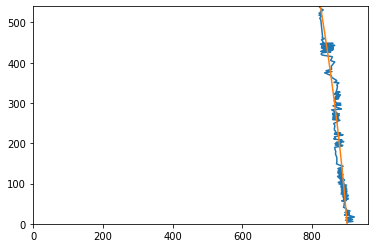

(1, 1080, 2)
[-1.64959118e-04 -5.17852917e-02  8.95241599e+02]


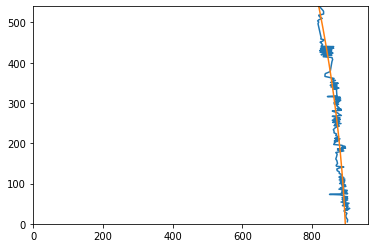

KeyboardInterrupt: 

In [17]:
import numpy as np
import cv2
import collections
import matplotlib.pyplot as plt
imshape=(1920//2, 1080//2)

roi_vertices = np.array([[575,350],[900,530],[50,530],[375,350]], dtype=np.int32)
pts=np.float32([[375,350],[575,350],[50,530],[900,530]])
pts2=np.float32([[250,0],[960,0],[250,540],[960,540]])

small_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (6, 6))

class Line():
    def __init__(self, maxSamples=8):

        self.maxSamples = maxSamples
        # x values of the last n fits of the line
        self.recent_xfitted = collections.deque(maxlen=self.maxSamples)
        # Polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        # Polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        # Average x values of the fitted line over the last n iterations
        self.bestx = None
        # Was the line detected in the last iteration?
        self.detected = False
        # How many points in the line in current frame?
        self.points = None
        # How many points in the line in last frame?
        self.points_last = None


    def update_lane(self, ally, allx):
        # Updates lanes on every new frame
        # Mean x value
        self.bestx = np.mean(allx, axis=0)
        # Fit 2nd order polynomial
        new_fit = np.polyfit(ally, allx, 2)
        # Update current fit
        self.current_fit = new_fit
        # Add the new fit to the queue
        self.recent_xfitted.append(self.current_fit)
        # Use the queue mean as the best fit
        self.best_fit = np.mean(self.recent_xfitted, axis=0)
def warp(img):
    matrix = cv2.getPerspectiveTransform(pts,pts2)
    result = cv2.warpPerspective(img,matrix, (960,540))
    Minv = cv2.getPerspectiveTransform(pts2,pts)
    return result, Minv
def slide_window(binary_warped):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    print('slide window')
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 50
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2)
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    if len(leftx)<500 or len(lefty)<500 or len(rightx)<500 or len(righty)<500:
        pass
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        window_img = np.zeros_like(out_img)
        left_line.points = len(leftx)
        right_line.points = len(rightx)

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.intc([left_line_pts]), (0,255,0))
        cv2.fillPoly(window_img, np.intc([right_line_pts]), (0,255,0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]

        # Draw polyline on image
        right = np.asarray(tuple(zip(right_fitx, ploty)), np.int32)
        left = np.asarray(tuple(zip(left_fitx, ploty)), np.int32)
        cv2.polylines(out_img, [right], False, (1,1,0), thickness=5)
        cv2.polylines(out_img, [left], False, (1,1,0), thickness=5)

    return left_lane_inds, right_lane_inds, out_img
def margin_search(binary_warped):
    # Performs window search on subsequent frame, given previous frame.
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50

    #print(nonzero)

    left_lane_inds = ((nonzerox > (left_line.current_fit[0]*(nonzeroy**2) + left_line.current_fit[1]*nonzeroy + left_line.current_fit[2] - margin)) & (nonzerox < (left_line.current_fit[0]*(nonzeroy**2) + left_line.current_fit[1]*nonzeroy + left_line.current_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_line.current_fit[0]*(nonzeroy**2) + right_line.current_fit[1]*nonzeroy + right_line.current_fit[2] - margin)) & (nonzerox < (right_line.current_fit[0]*(nonzeroy**2) + right_line.current_fit[1]*nonzeroy + right_line.current_fit[2] + margin)))
    left_line.points = left_lane_inds.sum()
    right_line.points = right_lane_inds.sum()

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Generate a blank image to draw on
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Create an image to draw on and an image to show the selection window
    window_img = np.zeros_like(out_img)

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.intc([left_line_pts]), (0,255,0))
    cv2.fillPoly(window_img, np.intc([right_line_pts]), (0,255,0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]

    # Draw polyline on image
    right = np.asarray(tuple(zip(right_fitx, ploty)), np.int32)
    left = np.asarray(tuple(zip(left_fitx, ploty)), np.int32)
    cv2.polylines(out_img, [right], False, (1,1,0), thickness=5)
    cv2.polylines(out_img, [left], False, (1,1,0), thickness=5)

    return left_lane_inds, right_lane_inds, out_img

def validate_lane_update(img, left_lane_inds, right_lane_inds):
    # Checks if detected lanes are good enough before updating
    img_size = (img.shape[1], img.shape[0])

    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Extract left and right line pixel positions
    left_line_allx = nonzerox[left_lane_inds]
    left_line_ally = nonzeroy[left_lane_inds]
    right_line_allx = nonzerox[right_lane_inds]
    right_line_ally = nonzeroy[right_lane_inds]
    
    # Discard lane detections that have very little points,
    # as they tend to have unstable results in most cases
    if len(left_line_allx) <= 1000 or len(right_line_allx) <= 1000:
        left_line.detected = False
        right_line.detected = False
        return

    left_x_mean = np.mean(left_line_allx, axis=0)
    right_x_mean = np.mean(right_line_allx, axis=0)
    lane_width = np.subtract(right_x_mean, left_x_mean)

    # Discard the detections if lanes are not in their repective half of their screens
    if left_x_mean > 740 or right_x_mean < 740:
        left_line.detected = False
        right_line.detected = False
        return

    # Discard the detections if the lane width is too large or too small
    if  lane_width < 300 or lane_width > 800:
        left_line.detected = False
        right_line.detected = False
        return

    # If this is the first detection or
    # the detection is within the margin of the averaged n last lines
    if left_line.bestx is None or np.abs(np.subtract(left_line.bestx, np.mean(left_line_allx, axis=0))) < 100:
        left_line.update_lane(left_line_ally, left_line_allx)
        left_line.detected = True
    else:
        left_line.detected = False
    if right_line.bestx is None or np.abs(np.subtract(right_line.bestx, np.mean(right_line_allx, axis=0))) < 100:
        right_line.update_lane(right_line_ally, right_line_allx)
        right_line.detected = True
    else:
        right_line.detected = False
def assemble_img(warped, threshold_img, polynomial_img, lane_img):
    # Define output image
    # Main image
    img_out=np.zeros((540,1388,3), dtype=np.uint8)
    img_out[0:540,0:960,:] = lane_img

    # Text formatting
    fontScale=1
    thickness=1
    fontFace = cv2.FONT_HERSHEY_PLAIN

    # Perspective transform image
    img_out[0:180,961:1388,:] = cv2.resize(warped,(427,180))
    boxsize, _ = cv2.getTextSize("Transformed", fontFace, fontScale, thickness)
    cv2.putText(img_out, "Transformed", (int(1494-boxsize[0]/2),40), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)

    # Threshold image
    resized = cv2.resize(threshold_img,(427,180))
    resized=np.uint8(resized)
    gray_image = cv2.cvtColor(resized*255,cv2.COLOR_GRAY2RGB)
    img_out[181:361,961:1388,:] = cv2.resize(gray_image,(427,180))
    boxsize, _ = cv2.getTextSize("Filtered", fontFace, fontScale, thickness)
    cv2.putText(img_out, "Morph points: {}".format(morph_points), (1050,20), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, "Color threshold: {}".format(*thresh_s), (1050,70), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)

    # Polynomial lines
    img_out[360:540,961:1388,:] = cv2.resize(polynomial_img*255,(427,180))
    boxsize, _ = cv2.getTextSize("Detected Lanes", fontFace, fontScale, thickness)

    return img_out

def morphology_filter(img_):
    gray = cv2.cvtColor(img_, cv2.COLOR_RGB2GRAY)
    # Saturation channel
    #hls_s = cv2.cvtColor(img_, cv2.COLOR_RGB2HLS)[:, :, 2]
    # Combination of grayscale and saturation helps make lanes more defined
    #src = 0.3*hls_s + 0.7*gray
    src = gray
    src = np.array(src-np.min(src)/(np.max(src)-np.min(src))).astype('float32')
    blurf = np.zeros((1, 5))
    blurf.fill(1)
    src = cv2.filter2D(src, cv2.CV_32F, blurf)
    f = np.zeros((1, 30))
    f.fill(1)
    l = cv2.morphologyEx(src, cv2.MORPH_OPEN, f)
    # l is our src image with an opening morphological transformation applied to it. Anything smaller than some value in kernel will be removed. This means smaller abnormalities like lane lines are removed, and nautral gradients like shadows are not. Subtracting them yields the removed items. This is the top hat morphological transformation.
    filtered = src - l
    # 6x6 kernel

    morph_thresh_lower = 1.1*np.mean(filtered) + .7*np.std(filtered)
    morph_binary = np.zeros_like(filtered)
    morph_binary[(filtered >= morph_thresh_lower)] = 1
    # Remove noise with 6x6 kernel
   # morph_binary = cv2.morphologyEx(morph_binary, cv2.MORPH_OPEN, small_kernel)
    morph_binary=morph_binary.astype(np.float32)

    global morph_points
    morph_points = np.sum(morph_binary)

    return morph_binary

def draw_lane(undist, img, Minv):
    # Generate x and y values for plotting
    ploty = np.linspace(0, undist.shape[0] - 1, undist.shape[0])
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img).astype(np.uint8)
    color_warp = np.stack((warp_zero, warp_zero, warp_zero), axis=-1)

    left_fit = left_line.best_fit
    right_fit = right_line.best_fit

    if left_fit is not None and right_fit is not None:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (64, 224, 208))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0]))

        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

        return result
    return undist

def ransac_polyfit(thresh, order=3, n=20, k=100, t=10, d=100, f=0.8):
  # thresh - thresholded image
  # n – minimum number of data points required to fit the model
  # k – maximum number of iterations allowed in the algorithm
  # t – threshold value to determine when a data point fits a model
  # d – number of close data points required to assert that a model fits well to data
  # f – fraction of close data points required

    # Convert thresholded image to x/y indices 
    nonzero = thresh.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50

    # Distinguish between right and left lane - margin search
    left_lane_inds = ((nonzerox > (left_line.current_fit[0]*(nonzeroy**2) + left_line.current_fit[1]*nonzeroy + left_line.current_fit[2] - margin)) & (nonzerox < (left_line.current_fit[0]*(nonzeroy**2) + left_line.current_fit[1]*nonzeroy + left_line.current_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_line.current_fit[0]*(nonzeroy**2) + right_line.current_fit[1]*nonzeroy + right_line.current_fit[2] - margin)) & (nonzerox < (right_line.current_fit[0]*(nonzeroy**2) + right_line.current_fit[1]*nonzeroy + right_line.current_fit[2] + margin)))
    
    # Generate plot of just right lane for debugging
    debugging = np.array(np.zeros_like(thresh))
    rightx = nonzerox[right_lane_inds] - 1
    righty = thresh.shape[0] -nonzeroy[right_lane_inds] - 1

    while len(rightx)+len(righty) > 500:
        rightx = rightx[0::2]
        righty = righty[0::2]

    debugging[righty, rightx] = 1
    debugging = debugging.astype(np.int32)

    besterr = np.inf
    bestfit = None

    for kk in range(k):
        maybeinliers = np.random.randint(len(righty), size=n)        
        maybemodel = np.polyfit(righty[maybeinliers], rightx[maybeinliers], order)
        alsoinliers = np.abs(np.polyval(maybemodel, righty)-rightx) < t
        if sum(alsoinliers) > len(righty)*f  and sum(alsoinliers) > d:
            bettermodel = np.polyfit(righty[alsoinliers], rightx[alsoinliers], order)
            thiserr = np.sum(np.abs(np.polyval(bettermodel, righty[alsoinliers])-rightx[alsoinliers]))
            if thiserr < besterr:
                bestfit = bettermodel
                besterr = thiserr
    ploty = np.linspace(0, thresh.shape[1] - 1, thresh.shape[1])
    right_fitx = bestfit[0]*ploty**2 + bestfit[1]*ploty + bestfit[2]
    #right_fitx = bestfit[0]*ploty + bestfit[1]
    #pts_right = np.array([np.transpose(np.vstack([right_fitx, ploty]))])  
    plt.plot(rightx,righty)
    plt.plot(right_fitx,ploty)
    plt.ylim(0,540)
    plt.xlim(0,960)


    # Generate a blank image to draw on
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Create an image to draw on and an image to show the selection window
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]

    # Draw polyline on image
    right = np.asarray(tuple(zip(right_fitx, ploty)), np.int32)
    left = np.asarray(tuple(zip(left_fitx, ploty)), np.int32)
    cv2.polylines(out_img, [right], False, (1,1,0), thickness=5)
    cv2.polylines(out_img, [left], False, (1,1,0), thickness=5)
    return bestfit



def process_frame(img):
    # Resizing & Copy
    img=cv2.resize(img, imshape)
    img_original = np.copy(img)
    # Bird's eye view
    warped, Minv = warp(img)

    # Morphological threshold
    morph_thresh = morphology_filter(warped)
    
    # Small kernel for filtering noise
    morph_thresh = cv2.morphologyEx(morph_thresh, cv2.MORPH_OPEN, small_kernel)

    # Scan for lane lines using a margin search, otherwise use a sliding window search
    if left_line.detected and right_line.detected:
        left_lane_inds, right_lane_inds, output = margin_search(morph_thresh)
        validate_lane_update(morph_thresh, left_lane_inds, right_lane_inds)

    else:
        left_lane_inds, right_lane_inds, output = slide_window(morph_thresh)
        validate_lane_update(morph_thresh, left_lane_inds, right_lane_inds)
   
    fit = ransac_polyfit(morph_thresh, order=2, n=50, k=200, t=50, d=50, f=0.8)
      # n – minimum number of data points required to fit the model
     # k – maximum number of iterations allowed in the algorithm
    # t – threshold value to determine when a data point fits a model
      # d – number of close data points required to assert that a model fits well to data
     # f – fraction of close data points required
    print(fit)
    plt.show()
    # Done!
    final = draw_lane(img_original, morph_thresh, Minv)
    result = assemble_img(warped, morph_thresh, output, final)
    
    
    return result


if __name__ == "__main__":
  #cap = cv2.VideoCapture('C:/Users/turbo/Documents/Lane-finder/Lane-Finder/Input_videos/obstacle_challenge.mp4')
  cap = cv2.VideoCapture("C:/Users/turbo/Documents/Lane-finder/Lane-Finder/Input_videos/shadow_challenge.mp4")
  #cap = cv2.VideoCapture("C:/Users/turbo/Documents/Lane-finder/Lane-Finder/Input_videos/harder_challenge_video.mp4")

  left_line = Line()
  right_line = Line()
  thresh_s = [170, 255]
  thresh_l = [145, 255]
  writer = None
  while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Not grabbed.")
        break
        
    # Run detection
    if right_line.points is not None:
        right_line.points_last, left_line.points_last = right_line.points, left_line.points
    result = process_frame(frame)
    cv2.imshow('image', result) 
    cv2.waitKey(0)
    cv2.destroyAllWindows()